In [ ]:
pip install pandas

Working Code

In [ ]:
import pandas as pd
import re
log_pattern = re.compile(r'(\S+) - - \[([^\]]+)\] "(\S+ [^"]* [^"]*)" (\d+) (\d+) "([^"]*)" "([^"]*)"')
with open("/content/web.log", "r") as file:
    log_lines = file.readlines()
def extract_info(log_entry):
    parts = re.split(r'\s+', log_entry.strip())
    if len(parts) >= 12:
        ip_address = parts[0]
        timestamp = parts[3] + ' ' + parts[4].replace('[', '')
        request = ' '.join(parts[5:8])
        status_code = parts[8]
        bytes_sent = parts[9]
        referrer = parts[10].replace('"', '')
        user_agent = ' '.join(parts[11:]).replace('"', '')
        return ip_address, timestamp, request, status_code, bytes_sent, referrer, user_agent
    else:
        print("Log entry did not match the expected format:", log_entry)
        return None
valid_logs = []
current_log_entry = ""
for line in log_lines:
    current_log_entry += line
    if 'HTTP' in line:
        log_info = extract_info(current_log_entry)
        if log_info is not None:
            valid_logs.append(log_info)
        current_log_entry = ""
if current_log_entry.strip():
    log_info = extract_info(current_log_entry)
    if log_info is not None:
        valid_logs.append(log_info)
columns = ["ip_address", "timestamp", "request", "status_code", "bytes", "referrer", "user_agent"]
log_df = pd.DataFrame(valid_logs, columns=columns)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 200)
print(log_df)

Log entry did not match the expected format: 186.179.78.230 - - [23/Sep/2023:12:46:30] "GET /networking/launch/ HTTP/2.0" 307 1199
           ip_address                     timestamp                                            request status_code          bytes  referrer                                      user_agent
0      88.211.105.115  [04/Mar/2022:14:17:48] "POST                   /history/missions/ HTTP/2.0" 414       12456       Caution:    System  may require attention. Check logs for details.
1        144.6.49.142  [02/Sep/2022:15:16:00] "POST                 /security/firewall/ HTTPS/1.0" 203       97126       Warning:   Unusual         behavior detected. Investigate further.
2       231.70.64.145   [19/Jul/2022:01:31:31] "PUT          /web-development/countdown/ HTTP/1.0" 201       33093  Informational  message.                             No action required.
3      219.42.234.172  [08/Feb/2022:11:34:57] "POST              /networking/technology/ HTTP/1.0" 415       68827   

SQL

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=67627da86efe1da34bb8192b8d11d75f17da4e49bf35e09950de584df9d01c4b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()
spark_log_df = spark.createDataFrame(log_df)
spark_log_df.createOrReplaceTempView("log_data_table")
#. Count the number of distinct IP addresses
distinct_ip_count = spark.sql("SELECT COUNT(DISTINCT ip_address) AS unique_ip_count FROM log_data_table")
distinct_ip_count.show()
#. Find the top 5 URLs with the highest number of requests
top_urls = spark.sql("SELECT request, COUNT(*) AS request_count FROM log_data_table GROUP BY request ORDER BY request_count DESC LIMIT 5")
top_urls.show()
#. Find the date with the highest number of requests
max_request_date = spark.sql("SELECT SUBSTRING_INDEX(timestamp, ':', 1) AS request_date, COUNT(*) AS request_count FROM log_data_table GROUP BY request_date ORDER BY request_count DESC LIMIT 1")
max_request_date.show()


+---------------+
|unique_ip_count|
+---------------+
|          94747|
+---------------+

+--------------------+-------------+
|             request|request_count|
+--------------------+-------------+
|/shuttle/launch/ ...|           35|
|/history/aws-cert...|           35|
|/security/apollo-...|           34|
|/software/technol...|           34|
|/web-development/...|           34|
+--------------------+-------------+

+------------+-------------+
|request_date|request_count|
+------------+-------------+
|[08/Jul/2022|          172|
+------------+-------------+



In [ ]:
pip install matplotlib

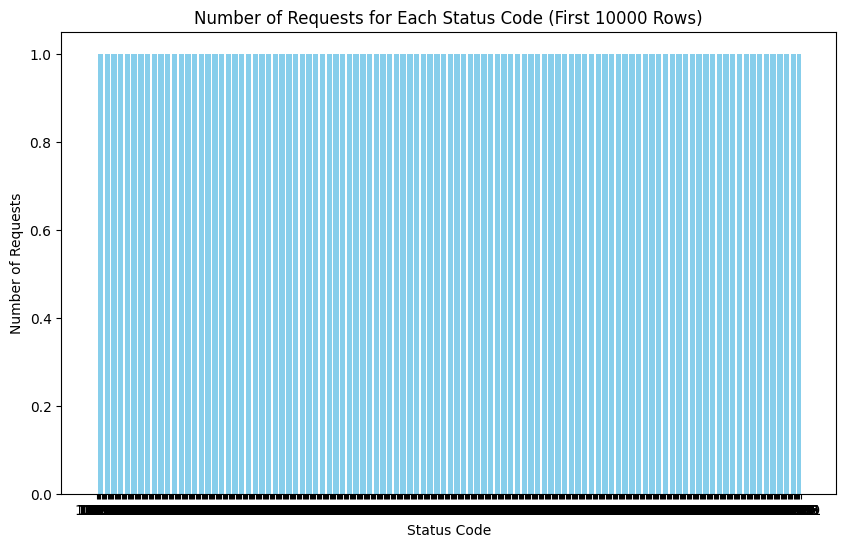

In [ ]:
import matplotlib.pyplot as plt
small_spark_log_df = spark_log_df.limit(600)
small_spark_log_df.createOrReplaceTempView("small_log_data_table")
status_counts = spark.sql("SELECT status_code, COUNT(*) AS count FROM small_log_data_table GROUP BY status_code ORDER BY status_code")
status_counts_pd = status_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(status_counts_pd['status_code'], status_counts_pd['count'], color='skyblue')
plt.xlabel('Status Code')
plt.ylabel('Number of Requests')
plt.title('Number of Requests for Each Status Code (First 10000 Rows)')
plt.show()

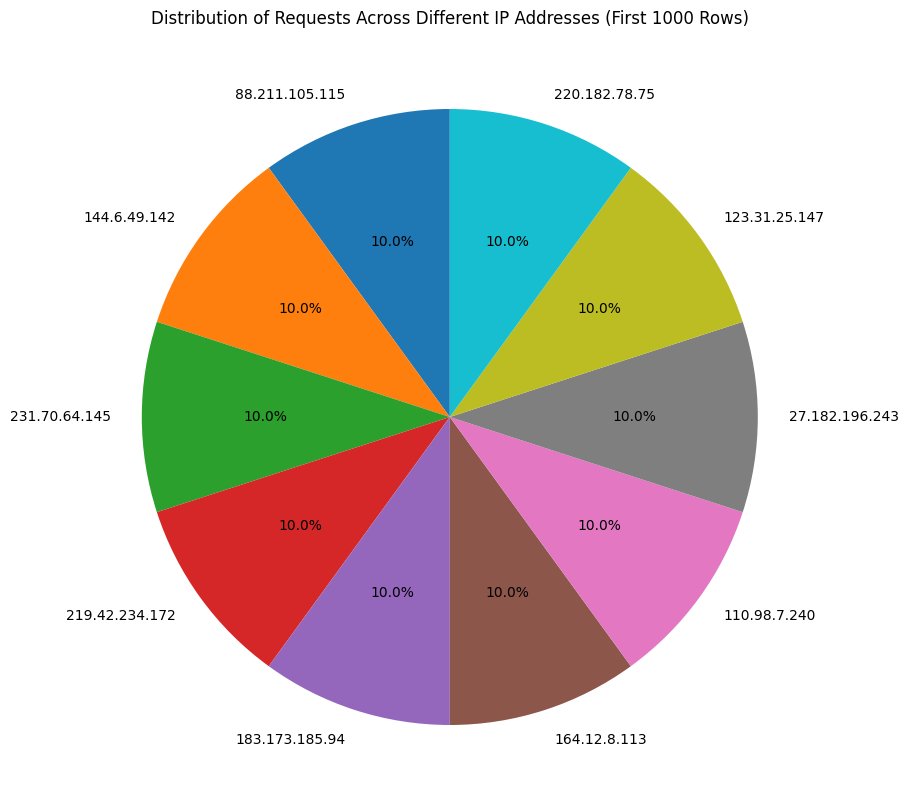

In [ ]:
import matplotlib.pyplot as plt
small_spark_log_df = spark_log_df.limit(500)
small_spark_log_df.createOrReplaceTempView("small_log_data_table")
ip_counts = spark.sql("SELECT ip_address, COUNT(*) AS count FROM small_log_data_table GROUP BY ip_address ORDER BY count DESC LIMIT 10")
ip_counts_pd = ip_counts.toPandas()
plt.figure(figsize=(10, 10))
plt.pie(ip_counts_pd['count'], labels=ip_counts_pd['ip_address'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Requests Across Different IP Addresses (First 1000 Rows)')
plt.show()

In [ ]:
small_spark_log_df = spark_log_df.limit(10)
small_spark_log_df.createOrReplaceTempView("small_log_data_table")
word_count_result = spark.sql("""
    SELECT word, COUNT(*) AS count
    FROM (
        SELECT EXPLODE(SPLIT(request, ' ')) AS word
        FROM small_log_data_table
    )
    GROUP BY word
    ORDER BY count DESC
""")
word_count_result.show()


+--------------------+-----+
|                word|count|
+--------------------+-----+
|           HTTP/2.0"|    4|
|           HTTP/1.0"|    4|
|                 414|    2|
| /security/firewall/|    2|
|          HTTPS/1.0"|    2|
|                 200|    2|
|                 204|    2|
|  /history/missions/|    1|
|                 203|    1|
|/web-development/...|    1|
|                 201|    1|
|/networking/techn...|    1|
|                 415|    1|
|                 205|    1|
|/web-development/...|    1|
|    /history/apollo/|    1|
| /history/apollo-11/|    1|
|/data-analysis/mi...|    1|
|    /history/launch/|    1|
+--------------------+-----+



In [ ]:
http_method_counts = spark.sql("""
    SELECT SUBSTRING_INDEX(SPLIT(request, ' ')[1], ' ', 1) AS http_method, COUNT(*) AS count
    FROM small_log_data_table
    GROUP BY http_method
    ORDER BY count DESC
""")
http_method_counts.show()



avg_bytes_by_method = spark.sql("""
    SELECT SUBSTRING_INDEX(SPLIT(request, ' ')[1], ' ', 1) AS http_method, AVG(bytes) AS avg_bytes
    FROM small_log_data_table
    GROUP BY http_method
""")
avg_bytes_by_method.show()


+-----------+-----+
|http_method|count|
+-----------+-----+
| HTTPS/1.0"|  221|
|  HTTP/2.0"|  199|
|  HTTP/1.0"|  180|
+-----------+-----+

+-----------+---------+
|http_method|avg_bytes|
+-----------+---------+
|  HTTP/2.0"|     NULL|
| HTTPS/1.0"|     NULL|
|  HTTP/1.0"|     NULL|
+-----------+---------+

